# Data Investigation - Trip Data

### Import Data

In [12]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set()

## Load Trip Data

In [13]:
print('Loading Trip Data...')

try:
    file_path_slug = '../../../datasets/bayareabikeshare/*_trip_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    trip_import = pd.DataFrame()

    counter = 1
    chunks = []

    # load data from each file
    for file in file_list:

        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            # set chunk index column to 'Trip ID'
            chunk = chunk.set_index('Trip ID')

            # define Columns
            chunk.columns = ['Duration', 'Start Date', 'Start Station', 'Start Terminal', 'End Date', 
                             'End Station', 'End Terminal', 'Bike #', 'Subscriber Type', 'Zip Code']

            # append chunk to chunks list
            chunks.append(chunk)

        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1

    # concat chunks
    trip_import = pd.concat(chunks)

    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')

Loading Trip Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


### Clean Data

In [14]:
trip_data = trip_import.copy()
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 10 columns):
Duration           983648 non-null int64
Start Date         983648 non-null object
Start Station      983648 non-null object
Start Terminal     983648 non-null int64
End Date           983648 non-null object
End Station        983648 non-null object
End Terminal       983648 non-null int64
Bike #             983648 non-null int64
Subscriber Type    983648 non-null object
Zip Code           976838 non-null object
dtypes: int64(4), object(6)
memory usage: 82.6+ MB


In [15]:
trip_data.head()

,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
Trip ID,,,,,,,,,,
913465,746,9/1/2015 0:10,San Francisco Caltrain 2 (330 Townsend),69,9/1/2015 0:23,San Francisco City Hall,58,238,Subscriber,94107
913466,969,9/1/2015 0:15,Clay at Battery,41,9/1/2015 0:31,Washington at Kearny,46,16,Subscriber,94133
913467,233,9/1/2015 0:15,Davis at Jackson,42,9/1/2015 0:19,Commercial at Montgomery,45,534,Subscriber,94111
913468,213,9/1/2015 1:29,Clay at Battery,41,9/1/2015 1:32,Steuart at Market,74,312,Subscriber,94107
913469,574,9/1/2015 1:33,Steuart at Market,74,9/1/2015 1:42,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107


In [16]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

In [19]:
print('Trip Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in trip_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
trip_data.columns = new_cols

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
trip_data = trip_data[important_cols]

# we are only looking at stations in San Francisco
# sf_trips_data = trip_data[trip_data['start_terminal'].isin(sf_stations)]
# sf_trips_data = sf_trips_data[sf_trips_data['end_terminal'].isin(sf_stations)]

# trip_data = sf_trips_data.copy()

# create duration minutes column
print('\tcreating a duration_minutes column')
trip_data['duration_minutes'] = trip_data['duration'] / 60.0

# convert end and start dates to datetime objects
print('\tconverting end and start dates to datetime objects')
trip_data['start_date'] = pd.to_datetime(trip_data['start_date'], format="%m/%d/%Y %H:%M")
trip_data['end_date']   = pd.to_datetime(trip_data['end_date'],   format="%m/%d/%Y %H:%M")

# create a start and end hour trip column
# print('\tcreating trip_date and trip_dow columns')
# trip_data['trip_date']  = trip_data['start_date'].dt.date
# trip_data['trip_dow']  = trip_data['start_date'].dt.weekday
# trip_data['trip_day']  = trip_data['start_date'].dt.weekday_name

# print('\tcreating start_hour and end_hour columns')
# trip_data['start_hour'] = trip_data['start_date'].dt.hour
# trip_data['end_hour']   = trip_data['end_date'].dt.hour

# convert and clean zipcodes
print('\tcleaning zipcodes')
trip_data['zip_code'] = trip_data['zip_code'].astype(str)
trip_data.zip_code = trip_data.zip_code.apply(clean_zipcode)
trip_data['zip_code'] = pd.to_numeric(trip_data['zip_code'], errors='coerce')

# clean up data types
print('cleaning up data types')

trip_data['duration']         = trip_data['duration'].astype('float')
trip_data['start_terminal']   = trip_data['start_terminal'].astype('category')
trip_data['end_terminal']     = trip_data['end_terminal'].astype('category')
trip_data['bike_#']           = trip_data['bike_#'].astype('int')
trip_data['subscriber_type']  = trip_data['subscriber_type'].astype('category')
trip_data['zip_code']         = trip_data['zip_code'].astype('str')
trip_data['duration_minutes'] = trip_data['duration_minutes'].astype('float')


print('Trip Data Cleanup complete')
trip_clean = trip_data.copy()

Trip Data Cleanup Started...
	cleaning column names
	subsetting to useful columns
	creating a duration_minutes column
	converting end and start dates to datetime objects
	cleaning zipcodes
cleaning up data types
Trip Data Cleanup complete


In [20]:
trip_clean.head()

,duration,start_date,start_terminal,end_date,end_terminal,bike_#,subscriber_type,zip_code,duration_minutes
Trip ID,,,,,,,,,
913465,746.0,2015-09-01 00:10:00,69,2015-09-01 00:23:00,58,238,Subscriber,94107.0,12.433333
913466,969.0,2015-09-01 00:15:00,41,2015-09-01 00:31:00,46,16,Subscriber,94133.0,16.150000
913467,233.0,2015-09-01 00:15:00,42,2015-09-01 00:19:00,45,534,Subscriber,94111.0,3.883333
913468,213.0,2015-09-01 01:29:00,41,2015-09-01 01:32:00,74,312,Subscriber,94107.0,3.550000
913469,574.0,2015-09-01 01:33:00,74,2015-09-01 01:42:00,69,279,Subscriber,94107.0,9.566667


### Prune Data - Trip Duration

pruning data to trips no more than 60 minutes long...
	pruned data set 'trips' consists of 955557 entries


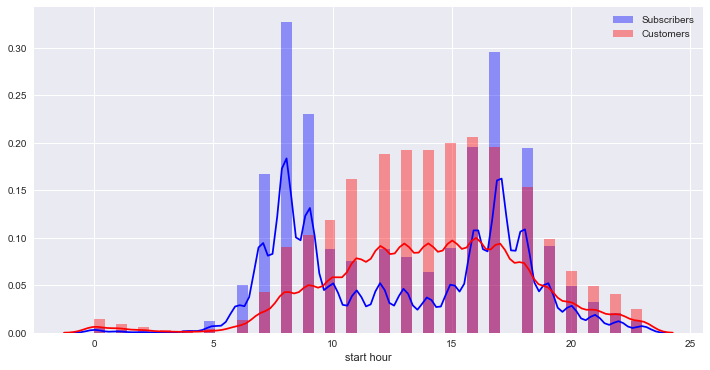

In [21]:
# prune data to exclude trips longer than 60 minutes
print('pruning data to trips no more than 60 minutes long...')
trips = trip_clean[trip_clean['duration_minutes'] <= 60].copy()

# Cleanup
trips.sort_index(inplace=True)
print('\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

plt.subplots(figsize=(12,6))
ax = sns.distplot(trips[trips.subscriber_type == 'Subscriber'].start_date.dt.hour, color='b', label='Subscribers')
sns.distplot(trips[trips.subscriber_type == 'Customer'].start_date.dt.hour, color='r', label='Customers', ax=ax)
ax.set(xlabel='start hour')
plt.legend()
plt.show()

In [22]:
# trips.to_csv('../../../datasets/bayareabikeshare/CLEANED/trips_cleaned_all.csv', encoding='utf-8')
trips_subscribers = trips[trips.subscriber_type == 'Subscriber']
# trips_subscribers.to_csv('../../../datasets/bayareabikeshare/CLEANED/trips_cleaned_subscribers.csv', encoding='utf-8')
trips_customers = trips[trips.subscriber_type == 'Customer']
# trips_customers.to_csv('../../../datasets/bayareabikeshare/CLEANED/trips_cleaned_customers.csv', encoding='utf-8')

In [9]:
print('trips:\t\t\t', len(trips))
print('trips_subscribers:\t' , len(trips_subscribers))
print('trips_customers:\t' , len(trips_customers))

trips:			 955557
trips_subscribers:	 844570
trips_customers:	 110987


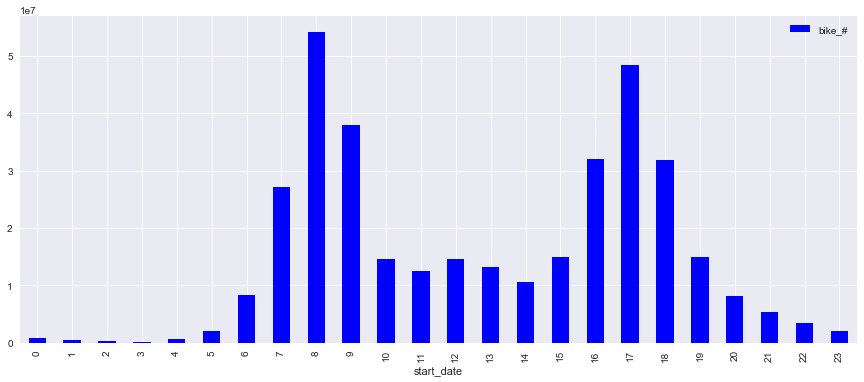

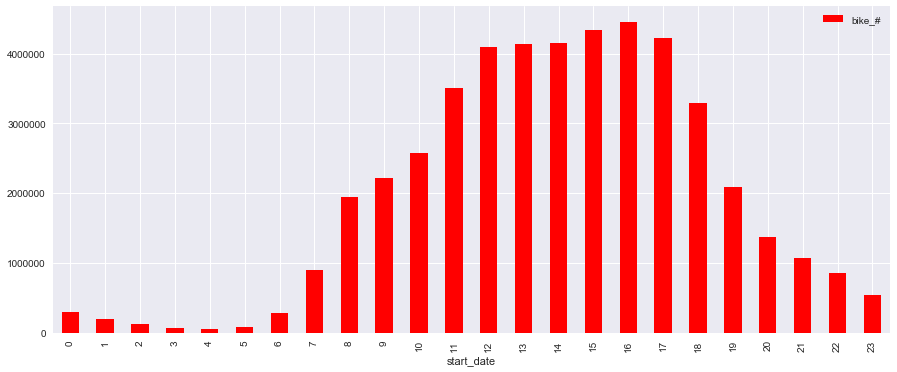

In [10]:
hourly_sub_trips = trips[trips.subscriber_type == 'Subscriber'].groupby(trips['start_date'].dt.hour)['bike_#'].sum().to_frame()
hourly_sub_trips.plot(kind='bar', color='b', figsize=(15,6))
plt.show()

hourly_cust_trips = trips[trips.subscriber_type == 'Customer'].groupby(trips['start_date'].dt.hour)['bike_#'].sum().to_frame()
hourly_cust_trips.plot(kind='bar', color='r', figsize=(15,6))
plt.show()

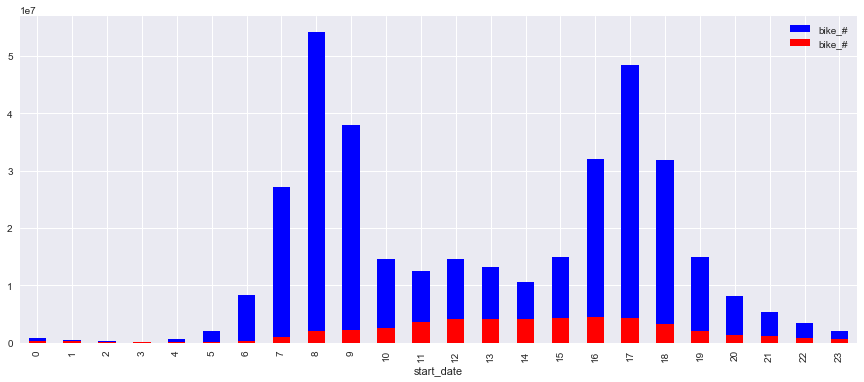

In [13]:
hourly_sub_trips = trips[trips.subscriber_type == 'Subscriber'].groupby(trips['start_date'].dt.hour)['bike_#'].sum().to_frame()
hourly_cust_trips = trips[trips.subscriber_type == 'Customer'].groupby(trips['start_date'].dt.hour)['bike_#'].sum().to_frame()


ax = hourly_sub_trips.plot(kind='bar', color='b', figsize=(15,6))
hourly_cust_trips.plot(kind='bar', color='r', ax=ax)
plt.show()

In [14]:
trips_subscribers = trips[trips['subscriber_type'] == 'Subscriber']
print('trips_subscribers contains %s rows' % len(trips_subscribers.index))
trips_customers   = trips[trips['subscriber_type'] == 'Customer']
print('trips_customers contains %s rows' % len(trips_customers.index))

trips_subscribers contains 844570 rows
trips_customers contains 110987 rows


In [15]:
print('trips_customers.duration_minutes.mean():\t', trips_customers.duration_minutes.mean())
print('trips_customers.duration_minutes.median():\t', trips_customers.duration_minutes.median())
print('trips_customers.duration_minutes.sum():\t\t', trips_customers.duration_minutes.sum())

print()
print('trips_subscribers.duration_minutes.mean():\t', trips_subscribers.duration_minutes.mean())
print('trips_subscribers.duration_minutes.median():\t', trips_subscribers.duration_minutes.median())
print('trips_subscribers.duration_minutes.sum():\t', trips_subscribers.duration_minutes.sum())

trips_customers.duration_minutes.mean():	 18.5433866128
trips_customers.duration_minutes.median():	 15.45
trips_customers.duration_minutes.sum():		 2058074.85

trips_subscribers.duration_minutes.mean():	 8.79435941761
trips_subscribers.duration_minutes.median():	 8.0
trips_subscribers.duration_minutes.sum():	 7427452.13333


### Popular stations for Subscribers

In [16]:
trips_subscribers.head()

,duration,start_date,start_terminal,end_date,end_terminal,bike_#,subscriber_type,zip_code,duration_minutes,trip_date,start_hour,end_hour
Trip ID,,,,,,,,,,,,
4069,174.0,2013-08-29 09:08:00,64,2013-08-29 09:11:00,64,288,Subscriber,94114.0,2.900000,2013-08-29,9,9
4073,1067.0,2013-08-29 09:24:00,66,2013-08-29 09:42:00,69,321,Subscriber,94703.0,17.783333,2013-08-29,9,9
4074,1131.0,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,317,Subscriber,94115.0,18.850000,2013-08-29,9,9
4075,1117.0,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,316,Subscriber,94122.0,18.616667,2013-08-29,9,9
4076,1118.0,2013-08-29 09:25:00,66,2013-08-29 09:43:00,69,322,Subscriber,94597.0,18.633333,2013-08-29,9,9


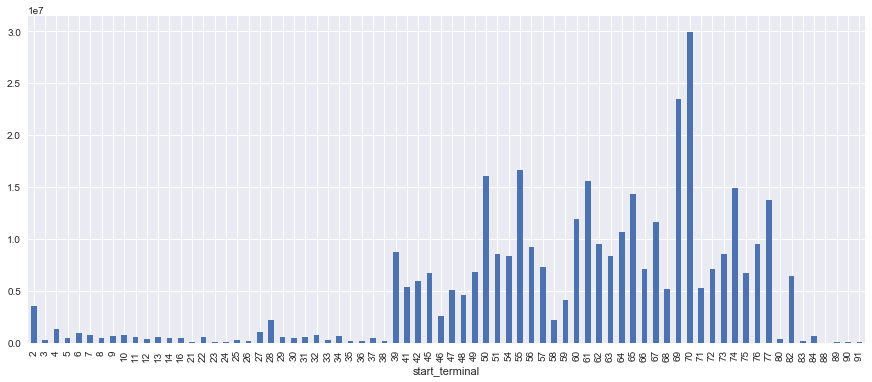

In [17]:
trips_subscribers.groupby('start_terminal')['bike_#'].sum().plot(kind='bar', figsize=(15,6))
plt.show()

In [18]:
sub_morning_commute = trips_subscribers[trips_subscribers.start_hour >= 7].copy()
sub_morning_commute = sub_morning_commute[sub_morning_commute.end_hour <= 11]

sub_evening_commute = trips_subscribers[trips_subscribers.start_hour >= 16].copy()
sub_evening_commute = sub_evening_commute[sub_evening_commute.end_hour <= 20]

In [21]:
sub_morning_commute.to_csv('../../../datasets/bayareabikeshare/CLEANED/trips_cleaned_subscribers_morning_commute.csv', encoding='utf-8')
sub_evening_commute.to_csv('../../../datasets/bayareabikeshare/CLEANED/trips_cleaned_subscribers_evening_commute.csv', encoding='utf-8')

In [20]:
print('sub_morning_commute\t', len(sub_morning_commute))
print('sub_evening_commute\t', len(sub_evening_commute))

sub_morning_commute	 340345
sub_evening_commute	 318936


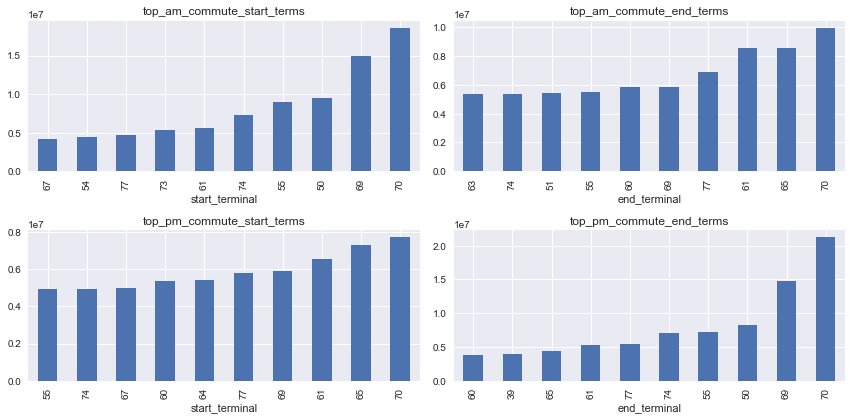

In [22]:
plt.subplot(2, 2, 1)
top_am_commute_start_terms = sub_morning_commute.groupby('start_terminal')['bike_#'].sum().sort_values().tail(15)
top_am_commute_start_terms.plot(kind='bar',figsize=(12,6))
plt.title('top_am_commute_start_terms')

plt.subplot(2, 2, 2)
top_am_commute_end_terms = sub_morning_commute.groupby('end_terminal')['bike_#'].sum().sort_values().tail(15)
top_am_commute_end_terms.plot(kind='bar')
plt.title('top_am_commute_end_terms')


plt.subplot(2, 2, 3)
top_pm_commute_start_terms = sub_evening_commute.groupby('start_terminal')['bike_#'].sum().sort_values().tail(15)
top_pm_commute_start_terms.plot(kind='bar')
plt.title('top_pm_commute_start_terms')

plt.subplot(2, 2, 4)
top_pm_commute_end_terms = sub_evening_commute.groupby('end_terminal')['bike_#'].sum().sort_values().tail(15)
top_pm_commute_end_terms.plot(kind='bar')
plt.title('top_pm_commute_end_terms')

plt.tight_layout()
plt.show()

## Lets Look at data for each bike in the program as well

In [35]:
trip_data.head()

,duration,start_date,start_terminal,end_date,end_terminal,bike_#,subscriber_type,zip_code,duration_minutes,trip_date,start_hour,end_hour
Trip ID,,,,,,,,,,,,
913465,746.0,2015-09-01 00:10:00,69,2015-09-01 00:23:00,58,238,Subscriber,94107.0,12.433333,2015-09-01,0,0
913466,969.0,2015-09-01 00:15:00,41,2015-09-01 00:31:00,46,16,Subscriber,94133.0,16.150000,2015-09-01,0,0
913467,233.0,2015-09-01 00:15:00,42,2015-09-01 00:19:00,45,534,Subscriber,94111.0,3.883333,2015-09-01,0,0
913468,213.0,2015-09-01 01:29:00,41,2015-09-01 01:32:00,74,312,Subscriber,94107.0,3.550000,2015-09-01,1,1
913469,574.0,2015-09-01 01:33:00,74,2015-09-01 01:42:00,69,279,Subscriber,94107.0,9.566667,2015-09-01,1,1


In [55]:
test = trip_data.reset_index()[['bike_#', 'start_terminal', 'end_terminal']].sort_values('bike_#')
test.head()

,bike_#,start_terminal,end_terminal
603864,9,84,6
131956,9,28,27
213258,9,69,56
326448,9,35,35
95728,9,2,7


In [60]:
trip_data.columns

# ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type']

Index(['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal',
       'bike_#', 'subscriber_type', 'zip_code', 'duration_minutes',
       'trip_date', 'start_hour', 'end_hour'],
      dtype='object')

In [104]:
for i in ['start_terminal', 'end_terminal', 'bike_#', 'subscriber_type']:
    u = pd.unique(trip_data[i])
    print(i, ' ', len(u))
    print(sorted(u))

start_terminal   74
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83, 84, 88, 89, 90, 91]
end_terminal   74
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 82, 83, 84, 88, 89, 90, 91]
bike_#   700
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 1

In [66]:
trip_data.head()

,duration,start_date,start_terminal,end_date,end_terminal,bike_#,subscriber_type,zip_code,duration_minutes,trip_date,start_hour,end_hour
Trip ID,,,,,,,,,,,,
913465,746.0,2015-09-01 00:10:00,69,2015-09-01 00:23:00,58,238,Subscriber,94107.0,12.433333,2015-09-01,0,0
913466,969.0,2015-09-01 00:15:00,41,2015-09-01 00:31:00,46,16,Subscriber,94133.0,16.150000,2015-09-01,0,0
913467,233.0,2015-09-01 00:15:00,42,2015-09-01 00:19:00,45,534,Subscriber,94111.0,3.883333,2015-09-01,0,0
913468,213.0,2015-09-01 01:29:00,41,2015-09-01 01:32:00,74,312,Subscriber,94107.0,3.550000,2015-09-01,1,1
913469,574.0,2015-09-01 01:33:00,74,2015-09-01 01:42:00,69,279,Subscriber,94107.0,9.566667,2015-09-01,1,1


In [72]:
bike_start_terms = trip_data.groupby('bike_#')['start_terminal'].value_counts().to_frame()
bike_end_terms = trip_data.groupby('bike_#')['end_terminal'].value_counts().to_frame()

In [74]:
bike_start_terms.head()

start_terminal
bike_# start_terminal                
9      2                           53
       28                          47
       27                          24
       35                          22
       32                          19

In [75]:
bike_end_terms.head()

end_terminal
bike_# end_terminal              
9      2                       55
       28                      44
       27                      28
       35                      25
       32                      17

In [90]:
bike_terms = pd.DataFrame()
bike_terms['start_terminal'] = trip_data.groupby('bike_#')['start_terminal'].value_counts()
bike_terms['end_terminal'] = trip_data.groupby('bike_#')['end_terminal'].value_counts()
bike_terms.index.names = ['bike_id', 'terminal']
bike_terms.head()

start_terminal  end_terminal
bike_id terminal                              
9       2                     53          55.0
        28                    47          44.0
        27                    24          28.0
        35                    22          25.0
        32                    19          17.0

In [92]:
bike_terms.to_csv('../../../datasets/bayareabikeshare/CLEANED/bike_terminal_visit_frequency.csv', encoding='utf-8')

In [97]:
bike_start_terminal_grid = bike_terms.unstack()['start_terminal']
bike_end_terminal_grid = bike_terms.unstack()['end_terminal']

terminal,2,3,4,5,6,7,8,9,10,11,...,76,77,80,82,83,84,88,89,90,91
bike_id,,,,,,,,,,,,,,,,,,,,,
9,53.0,5.0,15.0,6.0,12.0,8.0,5.0,11.0,13.0,12.0,...,2.0,2.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN
10,40.0,8.0,11.0,2.0,13.0,10.0,12.0,8.0,16.0,7.0,...,NaN,NaN,1.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN
11,46.0,9.0,29.0,3.0,14.0,14.0,8.0,12.0,11.0,19.0,...,NaN,NaN,1.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN
12,24.0,7.0,9.0,4.0,7.0,7.0,9.0,10.0,7.0,7.0,...,NaN,NaN,2.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN
13,10.0,2.0,5.0,NaN,1.0,2.0,1.0,NaN,2.0,2.0,...,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN
14,35.0,7.0,10.0,4.0,14.0,6.0,5.0,8.0,5.0,11.0,...,5.0,3.0,2.0,10.0,NaN,1.0,NaN,NaN,NaN,NaN
15,46.0,7.0,20.0,6.0,13.0,11.0,5.0,13.0,6.0,3.0,...,7.0,8.0,NaN,3.0,4.0,3.0,NaN,NaN,3.0,NaN
16,8.0,NaN,6.0,2.0,8.0,4.0,5.0,5.0,1.0,1.0,...,58.0,77.0,NaN,41.0,NaN,NaN,NaN,NaN,1.0,NaN
17,75.0,18.0,30.0,10.0,23.0,15.0,6.0,6.0,12.0,12.0,...,NaN,NaN,18.0,NaN,NaN,27.0,NaN,NaN,NaN,NaN


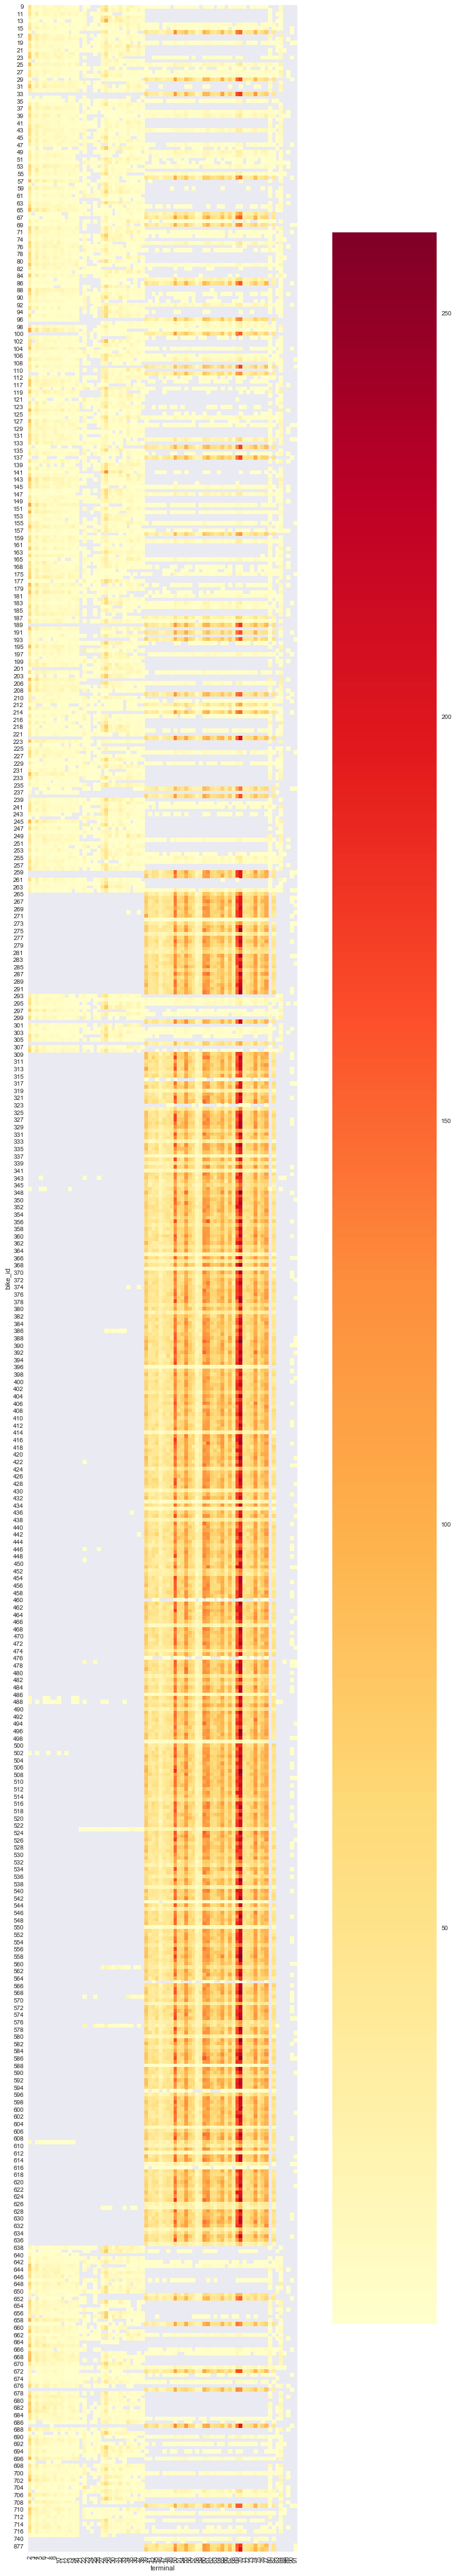

In [117]:
# sns.heatmap(bike_start_terminal_grid)

plt.subplots(figsize=(20,75))
sns.heatmap(bike_start_terminal_grid, square=True, cmap="YlOrRd")
ax.set(ylabel='Bike ID')
ax.set(xlabel='Start Terminal')
ax.set(title='Bike Start Terminal Heatmap')
plt.show()

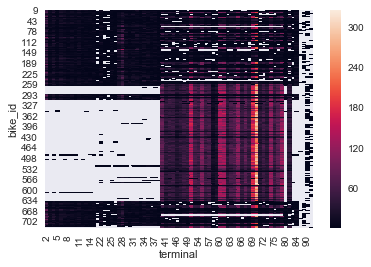

In [100]:
sns.heatmap(bike_end_terminal_grid)

In [58]:
bike_data = pd.DataFrame()

bike_first_trip = trip_data.groupby('bike_#')['start_date'].min()
bike_last_trip = trip_data.groupby('bike_#')['start_date'].max()
bike_trip_count = trip_data.groupby('bike_#')['start_date'].count()

bike_first = bike_first_trip.to_frame()
bike_last  = bike_last_trip.to_frame()
bike_trips = bike_trip_count.to_frame()

bike_data = pd.concat([bike_first, bike_last, bike_trips], axis=1)

bike_data.columns = ['first_trip', 'last_trip', 'trip_count']

bike_data['days_in_service'] = (bike_data['last_trip'] - bike_data['first_trip']).dt.days

bike_data.reset_index(inplace=True)
bike_data.columns = ['bike_id', 'first_trip', 'last_trip', 'trip_count', 'days_in_service']

last_recorded_trip = bike_data.last_trip.max()
bike_data['days_since_last_trip'] = (last_recorded_trip - bike_data.last_trip).dt.days

In [28]:
bike_data.head()
bike_data.to_csv('../../../datasets/bayareabikeshare/CLEANED/bike_data_cleaned.csv', encoding='utf-8')

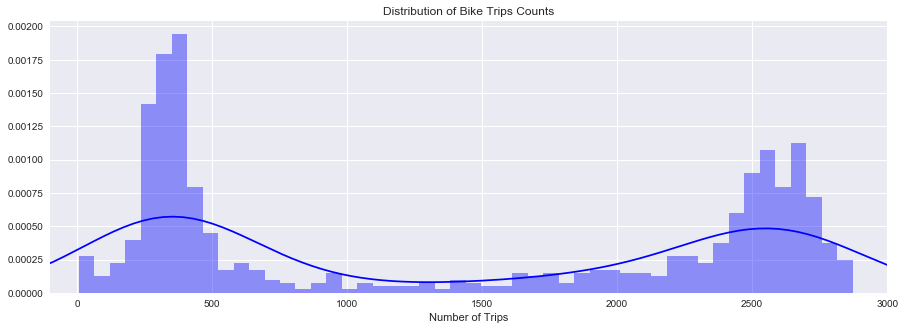

In [29]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_data.trip_count, color='b', bins=50)
plt.title('Distribution of Bike Trips Counts')
plt.xlim(-100, 3000)
plt.xlabel('Number of Trips')
plt.show()

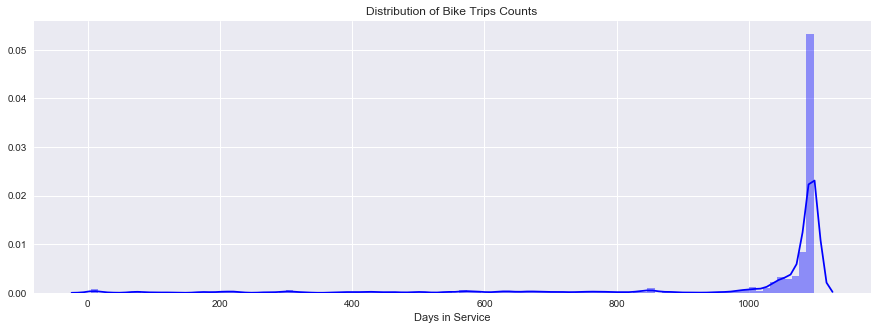

In [30]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_data.days_in_service, color='b', bins=100)
plt.title('Distribution of Bike Trips Counts')
plt.xlabel('Days in Service')
plt.show()

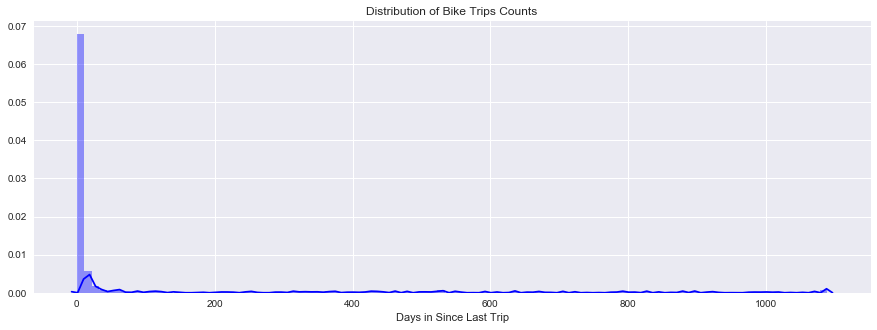

In [31]:
plt.subplots(figsize=(15,5))
sns.distplot(bike_data.days_since_last_trip, color='b', bins=100)
plt.title('Distribution of Bike Trips Counts')
plt.xlabel('Days in Since Last Trip')
plt.show()

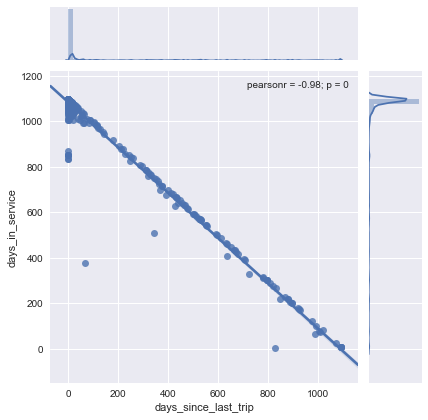

In [32]:
sns.jointplot(x='days_since_last_trip', y='days_in_service', data=bike_data, kind='reg')

In [ ]:
bike_data_subset = bike_data[bike_data.days_since_last_trip < 200].copy()
bike_data_subset = bike_data_subset[bike_data_subset.days_in_service > 800]
sns.jointplot(x='days_since_last_trip', y='days_in_service', data=bike_data_subset, kind='reg')

In [ ]:
# number of trips per bike, vs days in service
sns.jointplot(x='days_in_service', y='trip_count', data=bike_data, kind='reg')

In [ ]:
sns.jointplot(x='days_since_last_trip', y='trip_count', data=bike_data, kind='reg')

In [ ]:
sns.jointplot(x='days_since_last_trip', y='trip_count', data=bike_data[bike_data.trip_count <= 1000], kind='reg')

In [ ]:
sns.jointplot(x='days_since_last_trip', y='trip_count', data=bike_data[bike_data.trip_count > 1000], kind='reg')

In [ ]:
route_data = trip_clean.groupby(['start_terminal', 'end_terminal'])['bike_#'].count()

In [ ]:
grid = route_data.unstack()

In [ ]:
sj_terminals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 80, 84, 89, 88]
rc_terminals = [21, 22, 23, 24, 25, 26, 83]
mv_terminals = [27, 28, 29, 30, 31, 32, 33]
pa_terminals = [34, 35, 36, 37, 38]
sf_terminals = [39, 41, 42, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82, 90, 91]


not_sj_terminals = rc_terminals + mv_terminals + pa_terminals + sf_terminals 
not_rc_terminals = sj_terminals + mv_terminals + pa_terminals + sf_terminals 
not_mv_terminals = sj_terminals + rc_terminals + pa_terminals + sf_terminals 
not_pa_terminals = sj_terminals + rc_terminals + mv_terminals + sf_terminals 
not_sf_terminals = sj_terminals + rc_terminals + mv_terminals + pa_terminals 

sj_routes = grid[grid.index.isin(sj_terminals)]
sj_routes = sj_routes.drop(not_sj_terminals, axis=1)
print('sj_routes:\t', len(sj_routes))

rc_routes = grid[grid.index.isin(rc_terminals)]
rc_routes = rc_routes.drop(not_rc_terminals, axis=1)
print('rc_routes:\t', len(rc_routes))

mv_routes = grid[grid.index.isin(mv_terminals)]
mv_routes = mv_routes.drop(not_mv_terminals, axis=1)
print('mv_routes:\t', len(mv_routes))

pa_routes = grid[grid.index.isin(pa_terminals)]
pa_routes = pa_routes.drop(not_pa_terminals, axis=1)
print('pa_routes:\t', len(pa_routes))

sf_routes = grid[grid.index.isin(sf_terminals)]
sf_routes = sf_routes.drop(not_sf_terminals, axis=1)
print('sf_routes:\t', len(sf_routes))

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(sj_routes, square=True, cmap="YlOrRd")
ax.set(ylabel='Start Terminal')
ax.set(xlabel='End Terminal')
ax.set(title='San Jose Starting Route Heatmap')
plt.show()

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(rc_routes, square=True, cmap="YlOrRd")
ax.set(ylabel='Start Terminal')
ax.set(xlabel='End Terminal')
ax.set(title='Redwood City Starting Route Heatmap')
plt.show()

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(mv_routes, square=True, cmap="YlOrRd")
ax.set(ylabel='Start Terminal')
ax.set(xlabel='End Terminal')
ax.set(title='Mountain View Route Heatmap')
plt.show()

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(pa_routes, square=True, cmap="YlOrRd")
ax.set(ylabel='Start Terminal')
ax.set(xlabel='End Terminal')
ax.set(title='Palo Alto Route Heatmap')
plt.show()

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(sf_routes, square=True, cmap="YlOrRd")
ax.set(ylabel='Start Terminal')
ax.set(xlabel='End Terminal')
ax.set(title='San Francisco Route Heatmap')
plt.show()

In [ ]:
plt.subplots(figsize=(10,10))
ax = sns.heatmap(grid, square=True, cmap="YlOrRd")

ax.set(ylabel='Start Terminal')
ax.set(xlabel='End Terminal')
ax.set(title='Route Heatmap')
plt.show()

In [ ]:
def get_route(series, one_way=True): 
    s = series['start_terminal']
    e = series['end_terminal']
    if one_way:
        return (series['start_terminal'], series['end_terminal'])
    else:
        if s < e:
            return (series['start_terminal'], series['end_terminal'])
        else:
            return (series['end_terminal'], series['start_terminal'])

In [ ]:
route_data = trip_clean.groupby(['start_terminal', 'end_terminal'])['bike_#'].count()
route_data = route_data.reset_index()
route_data['route'] = route_data.apply(get_route, axis=1)
route_data['terminals'] = route_data.apply(get_route, one_way=False, axis=1)

In [ ]:
# identify popular stations

start_terminal_trip_data = route_data.groupby('start_terminal')['bike_#'].sum()
start_terminal_data = start_terminal_trip_data.to_frame()
end_terminal_trip_data = route_data.groupby('end_terminal')['bike_#'].sum()
end_terminal_data = end_terminal_trip_data.to_frame()

ax = start_terminal_data.sort_values(['bike_#'], ascending=False).head(35).plot(kind='line', color='b', figsize=(18,6))
end_terminal_data.sort_values(['bike_#'], ascending=False).head(35).plot(kind='bar', color='g', ax=ax)
plt.legend(['Routes', 'Terminals'], loc='best')
plt.ylabel('Number of Trips')
plt.xlabel('Terminals')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Routes - All trips that start at a specific terminal and end a specific terminal
# Terminals - all trips that include a pair of specific terminals

routes_data = route_data.groupby('route')['bike_#'].sum()
terminals_data = route_data.groupby('terminals')['bike_#'].sum()
routes_data  = routes_data.to_frame()
terminals_data  = terminals_data.to_frame()

ax = routes_data.sort_values(['bike_#'], ascending=False).head(35).plot(kind='line', color='b', figsize=(18,6))
terminals_data.sort_values(['bike_#'], ascending=False).head(35).plot(kind='bar', color='g', ax=ax)
plt.legend(['Routes', 'Terminals'], loc='best')
plt.ylabel('Number of Trips')
plt.xlabel('Terminals')
plt.xticks(rotation=90)
plt.show()